In [ ]:
# https://medium.com/@coderhack.com/fine-tuning-bert-for-text-classification-a-step-by-step-guide-1a1c5f8e8ae1
# https://www.kaggle.com/code/neerajmohan/fine-tuning-bert-for-text-classification/notebook#Aproach

In [33]:
!pip install peft==0.10.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 10.3 MB/s eta 0:00:00


In [49]:
import numpy as np
import pandas as pd
import time
import datetime
import random

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from transformers import AdamW, get_linear_schedule_with_warmup, AutoTokenizer
from transformers import AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef

from peft import (
    LoraConfig,
    get_peft_model,
    TaskType
)

In [50]:
import warnings

warnings.filterwarnings('ignore')

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 1. Functions

#### 1.1 Max_len, Datasets, Dataloader etc.

In [4]:
def get_max_len(tweets, tokenizer):
    max_len = 0
    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [71]:
def create_dataset(tokenizer, labels_data, tweets_data, max_len):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset


In [6]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [7]:
def init_training(model, tokenizer, x_data, y_data):
    X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42,
                                                  stratify=y_data)
    max_len = get_max_len(x_data, tokenizer)

    train_data = create_dataset(tokenizer=tokenizer, labels_data=y_train,
                            tweets_data=X_train, max_len=max_len)
    val_data = create_dataset(tokenizer=tokenizer, labels_data=y_val,
                              tweets_data=X_val, max_len=max_len)

    train_dataloader = get_dataloader(batch_size=batch_size, dataset=train_data, sampler="random")
    val_dataloader = get_dataloader(batch_size=batch_size, dataset=val_data, sampler="sequential")

    optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_dataloader) * epochs)

    return train_dataloader, val_dataloader, optimizer, scheduler

In [8]:
def save_model(path, model, tokenizer):
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

In [37]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

#### 1.2 Evaluation functions

In [9]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [10]:
def calc_f1_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

In [11]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

#### 1.3 training, validation & test

In [13]:
def train_model(epochs, train_dataloader, validation_dataloader, optimizer, model, scheduler):
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    training_stats = []

    total_t0 = time.time()
    best_overall_eval_f1 = 0
    best_model = model
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            optimizer.zero_grad()
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels)
            loss = output.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        print("")
        print("Running Validation...")
        t0 = time.time()

        model.eval()
        total_eval_f1score = 0
        best_eval_f1score = best_overall_eval_f1
        total_eval_loss = 0
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():
                output = model(b_input_ids,
                               token_type_ids=None,
                               attention_mask=b_input_mask,
                               labels=b_labels)
            loss = output.loss
            total_eval_loss += loss.item()

            logits = output.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # calculate f1 score
            total_eval_f1score += calc_f1_score(logits, label_ids)

        avg_val_f1score = total_eval_f1score / len(validation_dataloader)
        print("  F1-Score (macro): {0:.2f}".format(avg_val_f1score))
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        if avg_val_f1score > best_eval_f1score:
            best_model = model
            best_overall_eval_f1 = avg_val_f1score
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. F1-Score (macro).': avg_val_f1score,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))

    return best_model

In [14]:
def evaluate(dataloader, model, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(input_ids=batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs[0]
        logits = outputs[1]
        total_loss += loss.item()
        predictions.append(logits.detach().cpu().numpy())
        true_labels.append(batch[2].detach().cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return total_loss / len(dataloader), predictions, true_labels

In [15]:
def test_model(model, tokenizer, x_data, y_data):
    batch_size=16
    max_len = get_max_len(x_data, tokenizer)
    test_data = create_dataset(tokenizer=tokenizer, labels_data=y_data,
                            tweets_data=X_test_tweets, max_len=max_len)
    test_dataloader = get_dataloader(batch_size=batch_size, dataset=test_data, sampler="sequential")


    test_loss, predictions, true_labels = evaluate(test_dataloader, model, device)
    preds_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_labels.flatten()

    test_acc = accuracy_score(labels_flat, preds_flat)
    test_precision = precision_score(labels_flat, preds_flat)
    test_recall = recall_score(labels_flat, preds_flat)
    test_f1 = f1_score(labels_flat, preds_flat, average='macro')
    test_mcc = matthews_corrcoef(labels_flat, preds_flat)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1: {test_f1}")
    print(f"Test MCC: {test_mcc}")

    class_names = ["No Hate-Speech", "Hate-Speech"]
    plot_confusion_matrix(labels_flat, preds_flat, class_names)
    report = classification_report(labels_flat, preds_flat, target_names=class_names)
    print("Classification Report:")
    print(report)

### 2. Daten

#### 2.1 Trainingsdaten

In [16]:
df_train = pd.read_csv("../data/train_cleaned.csv")
df_train = df_train[df_train.tweet_cleaned.notna() & df_train.tweet.notna()]

df_train.head()

,Unnamed: 0,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
0,140232,0,"Nicki's ""that's not good"" pout bought to you b...","nickis "" good pout buy botox trade mark mkr",0,['#mkr'],__trade_mark__
1,6083,0,@user @user @user @user @user @user greater g...,great game ever fun possible,6,"['#fun', '#possible']",NaN
2,62913,0,I love that you enjoy being trans.,love enjoy tran,0,[],NaN
3,13525,0,yes good shapely eurotrash manbooty,yes good eurotrash,0,[],NaN
4,6318,0,i can't wait for euro 2016 to sta on friday #e...,wait euro sta friday euro,0,['#euro2016'],NaN


##### 2.1.1 cleaned

In [17]:
X_train_tweets = df_train.tweet_cleaned.values
y_train_labels = df_train.label.values

##### 2.1.2 uncleaned

In [18]:
X_train_tweets_uncleaned = df_train.tweet.values

#### 2.2 Testdaten

In [19]:
df_test = pd.read_csv("../data/test_cleaned.csv")
df_test = df_test[df_test.tweet_cleaned.notna() & df_test.tweet.notna()]

df_test.head()

,Unnamed: 0,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
0,8886,0,@user #cinemaaawards final rehearsals!! geari...,final gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN
1,27613,0,this was amazing. the weather was not. #musica...,amazing weather musical london weekend …,0,"['#musical', '#london', '#matilda', '#westend'...",NaN
2,18952,0,child attacked by alligator at walt disney wor...,child attack alligator disney world,0,['#waltdisneyworld'],NaN
3,12485,0,me rn cause school is over soon,right cause school soon,0,[],NaN
4,5879,0,is it #good to #sleep when ? #good #sleep,good sleep good sleep,0,"['#good', '#sleep', '#good', '#sleep']",NaN


##### 2.1.1 cleaned

In [20]:
X_test_tweets = df_test.tweet_cleaned.values
y_test_labels = df_test.label.values

##### 2.1.2 uncleaned

In [21]:
X_test_tweets_uncleaned = df_test.tweet.values

### 3. Modelltraining

In [23]:
epochs = 5
batch_size = 16

#### 3.1 Modell A: RoBERTa - base sentiment

In [24]:
ROBERTA_SENTIMENT_MODEL_NAME_OR_PATH = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

In [25]:
roberta_sentiment_model_untrained = AutoModelForSequenceClassification.from_pretrained(
    ROBERTA_SENTIMENT_MODEL_NAME_OR_PATH,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True,
)
roberta_sentiment_model_untrained = roberta_sentiment_model_untrained.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

In [26]:
roberta_sentiment_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_SENTIMENT_MODEL_NAME_OR_PATH)

##### 3.1.1 Training 1 - mixed data cleaned

In [36]:
train_dataloader_sentiment, val_dataloader_sentiment, optimizer_sentiment, scheduler_sentiment = init_training(
    model=roberta_sentiment_model_untrained,
    tokenizer=roberta_sentiment_tokenizer,
    x_data=X_train_tweets,
    y_data=y_train_labels
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [37]:
trained_roberta_sentiment_tuned = train_model(
    epochs=epochs,
    train_dataloader=train_dataloader_sentiment,
    validation_dataloader=val_dataloader_sentiment,
    optimizer=optimizer_sentiment,
    scheduler=scheduler_sentiment,
    model=roberta_sentiment_model_untrained
)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.36
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.31
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.28
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.71

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.24
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.21
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.72

Training complete!
Total training took 0:39:13 (h:mm:ss)


###### Save Model

In [40]:
ROBERTA_SENTIMENT_MIXED_CLEANED_PATH = "models/roberta_sentiment_mixed_cleaned"

save_model(
    model=trained_roberta_sentiment_tuned,
    tokenizer=roberta_sentiment_tokenizer,
    path=ROBERTA_SENTIMENT_MIXED_CLEANED_PATH
)

###### Evaluate Model

Test Loss: 0.5865547293133339
Test Accuracy: 0.7789687673258178
Test Precision: 0.4805853208895034
Test Recall: 0.6098844860359701
Test F1: 0.6961736362646047
Test MCC: 0.3998586384435154


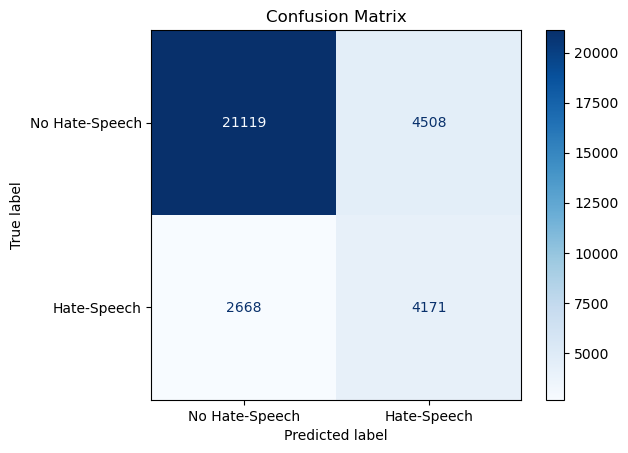

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.89      0.82      0.85     25627
   Hate-Speech       0.48      0.61      0.54      6839

      accuracy                           0.78     32466
     macro avg       0.68      0.72      0.70     32466
  weighted avg       0.80      0.78      0.79     32466



In [41]:
test_model(
    model=trained_roberta_sentiment_tuned,
    tokenizer=roberta_sentiment_tokenizer,
    y_data=y_test_labels,
    x_data=X_test_tweets
)

##### 3.1.2 Training 2 - mixed data uncleaned

In [27]:
train_dataloader_sentiment2, val_dataloader_sentiment2, optimizer_sentiment2, scheduler_sentiment2 = init_training(
    model=roberta_sentiment_model_untrained,
    tokenizer=roberta_sentiment_tokenizer,
    x_data=X_train_tweets,
    y_data=y_train_labels
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [28]:
trained_roberta_sentiment_tuned2 = train_model(
    epochs=epochs,
    train_dataloader=train_dataloader_sentiment2,
    validation_dataloader=val_dataloader_sentiment2,
    optimizer=optimizer_sentiment2,
    scheduler=scheduler_sentiment2,
    model=roberta_sentiment_model_untrained
)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.36
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.31
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.73

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.27
  Training epoch took: 0:07:15

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.24
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.73

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.21
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.72

Training complete!
Total training took 0:39:12 (h:mm:ss)


###### Save Model

In [29]:
ROBERTA_SENTIMENT_MIXED_CLEANED_PATH = "models/roberta_sentiment_mixed_uncleaned"

save_model(
    model=trained_roberta_sentiment_tuned2,
    tokenizer=roberta_sentiment_tokenizer,
    path=ROBERTA_SENTIMENT_MIXED_CLEANED_PATH
)

###### Evaluate Model

Test Loss: 0.5037000061773231
Test Accuracy: 0.8311464301115012
Test Precision: 0.6097718815725611
Test Recall: 0.5511039625676268
Test F1: 0.7366768327541895
Test MCC: 0.4746388400793382


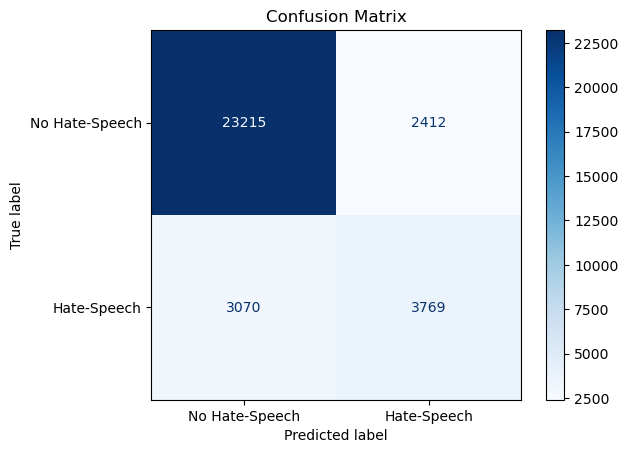

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.88      0.91      0.89     25627
   Hate-Speech       0.61      0.55      0.58      6839

      accuracy                           0.83     32466
     macro avg       0.75      0.73      0.74     32466
  weighted avg       0.83      0.83      0.83     32466



In [30]:
test_model(
    model=trained_roberta_sentiment_tuned2,
    tokenizer=roberta_sentiment_tokenizer,
    y_data=y_test_labels,
    x_data=X_test_tweets_uncleaned
)

##### 3.1.3 Training 3 - mixed data uncleaned (LoRA)

In [84]:
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)

In [85]:
peft_model_roberta_sentiment = get_peft_model(roberta_sentiment_model_untrained,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model_roberta_sentiment))

trainable model parameters: 1034498
all model parameters: 125681668
percentage of trainable model parameters: 0.82%


In [86]:
train_dataloader_sentiment_lora, val_dataloader_sentiment_lora, optimizer_sentiment_lora, scheduler_sentiment_lora = init_training(
    model=peft_model_roberta_sentiment,
    tokenizer=roberta_sentiment_tokenizer,
    x_data=X_train_tweets,
    y_data=y_train_labels
)

In [87]:
trained_roberta_sentiment_tuned_lora = train_model(
    epochs=epochs,
    train_dataloader=train_dataloader_sentiment_lora,
    validation_dataloader=val_dataloader_sentiment_lora,
    optimizer=optimizer_sentiment_lora,
    scheduler=scheduler_sentiment_lora,
    model=peft_model_roberta_sentiment
)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:07:56

Running Validation...
  F1-Score (macro): 0.71

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:08:01

Running Validation...
  F1-Score (macro): 0.71

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:07:57

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:07:51

Running Validation...
  F1-Score (macro): 0.71

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:07:51

Running Validation...
  F1-Score (macro): 0.71

Training complete!
Total training took 0:44:10 (h:mm:ss)


###### Save Model

In [88]:
ROBERTA_SENTIMENT_MIXED_CLEANED_LORA_PATH = "models/roberta_sentiment_mixed_uncleaned_lora"

save_model(
    model=trained_roberta_sentiment_tuned_lora,
    tokenizer=roberta_sentiment_tokenizer,
    path=ROBERTA_SENTIMENT_MIXED_CLEANED_LORA_PATH
)

###### Evaluate Model

Test Loss: 0.5166694581411145
Test Accuracy: 0.8297603646892133
Test Precision: 0.6038961038961039
Test Recall: 0.5575376517034654
Test F1: 0.7365247834882152
Test MCC: 0.4738562350596151


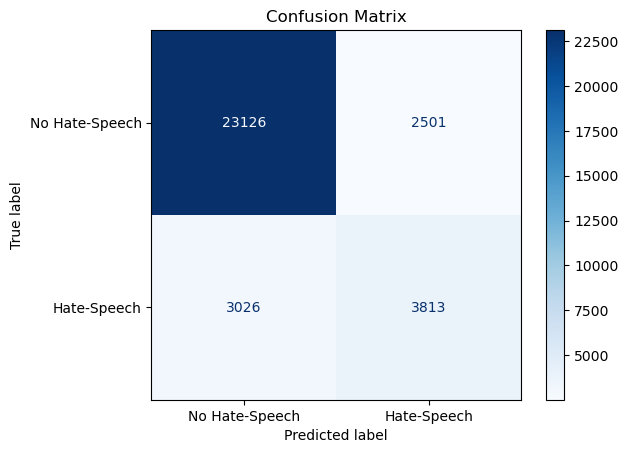

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.88      0.90      0.89     25627
   Hate-Speech       0.60      0.56      0.58      6839

      accuracy                           0.83     32466
     macro avg       0.74      0.73      0.74     32466
  weighted avg       0.83      0.83      0.83     32466



In [89]:
test_model(
    model=trained_roberta_sentiment_tuned_lora,
    tokenizer=roberta_sentiment_tokenizer,
    y_data=y_test_labels,
    x_data=X_test_tweets_uncleaned
)

#### 3.2 Modell B: RoBERTa - base hate

In [52]:
ROBERTA_HATE_MODEL_NAME_OR_PATH = f"cardiffnlp/twitter-roberta-base-hate-latest"

In [53]:
roberta_hate_model_untrained = AutoModelForSequenceClassification.from_pretrained(
    ROBERTA_HATE_MODEL_NAME_OR_PATH,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True,
)
roberta_hate_model_untrained = roberta_hate_model_untrained.to(device)

In [54]:
roberta_hate_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_HATE_MODEL_NAME_OR_PATH)

##### 3.2.1 Training 1 - mixed data cleaned

In [55]:
train_dataloader_hate, val_dataloader_hate, optimizer_hate, scheduler_hate = init_training(
    model=roberta_hate_model_untrained,
    tokenizer=roberta_hate_tokenizer,
    x_data=X_train_tweets,
    y_data=y_train_labels
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [56]:
trained_roberta_hate_tuned = train_model(
    epochs=epochs,
    train_dataloader=train_dataloader_hate,
    validation_dataloader=val_dataloader_hate,
    optimizer=optimizer_hate,
    scheduler=scheduler_hate,
    model=roberta_hate_model_untrained
)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.35
  Training epoch took: 0:07:15

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.31
  Training epoch took: 0:07:15

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.27
  Training epoch took: 0:07:15

Running Validation...
  F1-Score (macro): 0.72

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.24
  Training epoch took: 0:07:16

Running Validation...
  F1-Score (macro): 0.73

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.22
  Training epoch took: 0:07:15

Running Validation...
  F1-Score (macro): 0.72

Training complete!
Total training took 0:39:11 (h:mm:ss)


###### Save Model

In [57]:
ROBERTA_HATE_MIXED_CLEANED_PATH = "models/roberta_hate_mixed_cleaned"

save_model(
    model=trained_roberta_hate_tuned,
    tokenizer=roberta_hate_tokenizer,
    path=ROBERTA_HATE_MIXED_CLEANED_PATH
)

###### Evaluate Model

Test Loss: 0.4832593482728931
Test Accuracy: 0.8333025318795048
Test Precision: 0.6140687450039968
Test Recall: 0.5616318175171808
Test F1: 0.7411393732750371
Test MCC: 0.4832927760229322


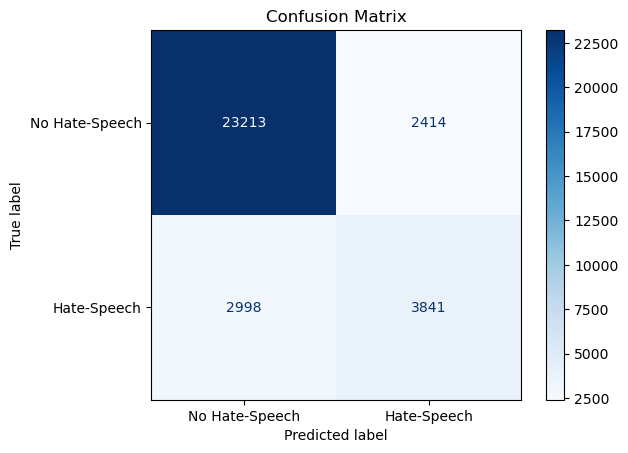

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.89      0.91      0.90     25627
   Hate-Speech       0.61      0.56      0.59      6839

      accuracy                           0.83     32466
     macro avg       0.75      0.73      0.74     32466
  weighted avg       0.83      0.83      0.83     32466



In [58]:
test_model(
    model=trained_roberta_hate_tuned,
    tokenizer=roberta_hate_tokenizer,
    y_data=y_test_labels,
    x_data=X_test_tweets
)

##### 3.2.2 Training 2 - mixed data uncleaned

In [72]:
train_dataloader_hate2, val_dataloader_hate2, optimizer_hate2, scheduler_hate2 = init_training(
    model=roberta_hate_model_untrained,
    tokenizer=roberta_hate_tokenizer,
    x_data=X_train_tweets_uncleaned,
    y_data=y_train_labels
)

In [75]:
trained_roberta_hate_tuned2 = train_model(
    epochs=epochs,
    train_dataloader=train_dataloader_hate2,
    validation_dataloader=val_dataloader_hate2,
    optimizer=optimizer_hate2,
    scheduler=scheduler_hate2,
    model=roberta_hate_model_untrained
)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.08
  Training epoch took: 0:11:04

Running Validation...
  F1-Score (macro): 0.75

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.06
  Training epoch took: 0:11:04

Running Validation...
  F1-Score (macro): 0.75

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.06
  Training epoch took: 0:11:04

Running Validation...
  F1-Score (macro): 0.75

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.07
  Training epoch took: 0:11:04

Running Validation...
  F1-Score (macro): 0.75

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.09
  Training epoch took: 0:11:04

Running Validation...
  F1-Score (macro): 0.75

Training complete!
Total training took 0:59:36 (h:mm:ss)


###### Save Model

In [76]:
ROBERTA_HATE_MIXED_CLEANED_PATH2 = "models/roberta_hate_mixed_uncleaned"

save_model(
    model=trained_roberta_hate_tuned2,
    tokenizer=roberta_hate_tokenizer,
    path=ROBERTA_HATE_MIXED_CLEANED_PATH2
)

###### Evaluate Model

Test Loss: 0.9645692438958083
Test Accuracy: 0.7959711698392165
Test Precision: 0.5133923009841784
Test Recall: 0.6025734756543354
Test F1: 0.7110570618826738
Test MCC: 0.42549061167812213


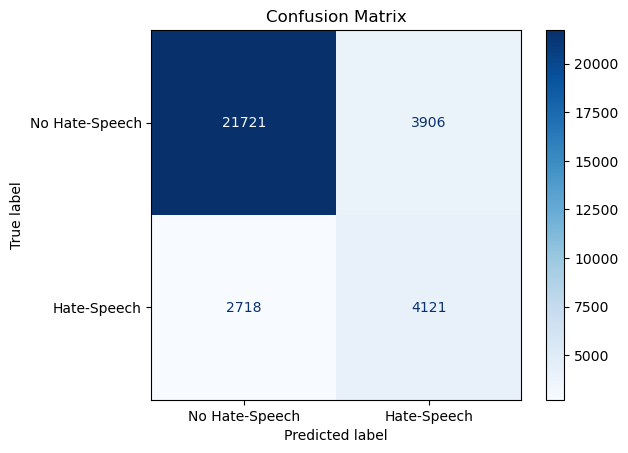

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.89      0.85      0.87     25627
   Hate-Speech       0.51      0.60      0.55      6839

      accuracy                           0.80     32466
     macro avg       0.70      0.73      0.71     32466
  weighted avg       0.81      0.80      0.80     32466



In [77]:
test_model(
    model=trained_roberta_hate_tuned2,
    tokenizer=roberta_hate_tokenizer,
    y_data=y_test_labels,
    x_data=X_test_tweets_uncleaned
)

##### 3.2.3 Training 3 - mixed data uncleaned (LoRA)

In [78]:
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)

In [79]:
peft_model_roberta_hate = get_peft_model(roberta_hate_model_untrained,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model_roberta_hate))

trainable model parameters: 1034498
all model parameters: 125681668
percentage of trainable model parameters: 0.82%


In [80]:
train_dataloader_hate_lora, val_dataloader_hate_lora, optimizer_hate_lora, scheduler_hate_lora = init_training(
    model=peft_model_roberta_hate,
    tokenizer=roberta_hate_tokenizer,
    x_data=X_train_tweets_uncleaned,
    y_data=y_train_labels
)

In [81]:
trained_roberta_hate_tuned_lora = train_model(
    epochs=epochs,
    train_dataloader=train_dataloader_hate_lora,
    validation_dataloader=val_dataloader_hate_lora,
    optimizer=optimizer_hate_lora,
    scheduler=scheduler_hate_lora,
    model=peft_model_roberta_hate
)


======== Epoch 1 / 5 ========
Training...

  Average training loss: 0.12
  Training epoch took: 0:07:52

Running Validation...
  F1-Score (macro): 0.75

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.11
  Training epoch took: 0:07:53

Running Validation...
  F1-Score (macro): 0.74

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.11
  Training epoch took: 0:07:53

Running Validation...
  F1-Score (macro): 0.74

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.11
  Training epoch took: 0:07:53

Running Validation...
  F1-Score (macro): 0.74

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.11
  Training epoch took: 0:07:53

Running Validation...
  F1-Score (macro): 0.74

Training complete!
Total training took 0:43:53 (h:mm:ss)


###### Save Model

In [82]:
ROBERTA_HATE_MIXED_CLEANED_PATH_LORA = "models/roberta_hate_mixed_uncleaned_lora"

save_model(
    model=trained_roberta_hate_tuned_lora,
    tokenizer=roberta_hate_tokenizer,
    path=ROBERTA_HATE_MIXED_CLEANED_PATH_LORA
)

###### Evaluate Model

Test Loss: 0.8420745914696508
Test Accuracy: 0.795355140762644
Test Precision: 0.5121951219512195
Test Recall: 0.5987717502558854
Test F1: 0.7097449764270309
Test MCC: 0.4226857776063508


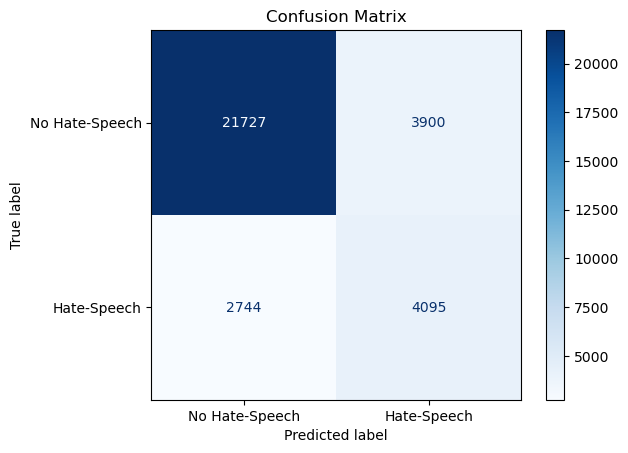

Classification Report:
                precision    recall  f1-score   support

No Hate-Speech       0.89      0.85      0.87     25627
   Hate-Speech       0.51      0.60      0.55      6839

      accuracy                           0.80     32466
     macro avg       0.70      0.72      0.71     32466
  weighted avg       0.81      0.80      0.80     32466



In [83]:
test_model(
    model=trained_roberta_hate_tuned_lora,
    tokenizer=roberta_hate_tokenizer,
    y_data=y_test_labels,
    x_data=X_test_tweets_uncleaned
)